## Reproduction of classic SCM experiments
The following **very informative material** was used as a reference <br>
["15 - Synthetic Control" Causal Inference for The Brave and True ](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html)

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID


In [2]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv"
)
raw_df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


In [3]:
df= raw_df.pivot(index='state', columns="year")["cigsale"].T
df.head()

state,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


In [4]:
#df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = [3] #"California"

sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)

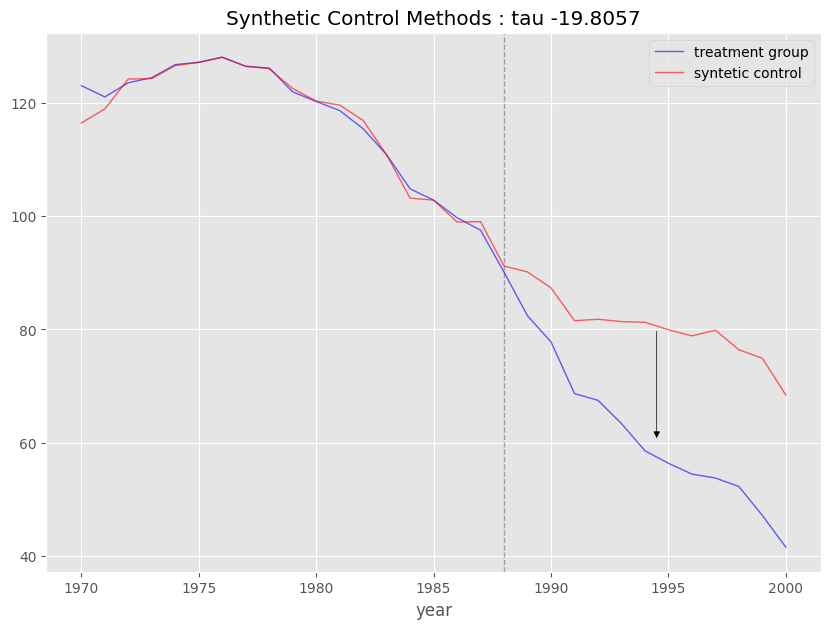

In [5]:
sdid.fit(zeta_type="base", simple_sc=True)
hat_omega_simple = sdid.estimated_params(model="sc")
sdid.plot(model="sc")

In [6]:
features = ["retprice", "age15to24"]

additional_df =  raw_df.query("year <= 1988").pivot(index='state', columns="year")[features].T
additional_df.head()

state                 1          2          3          4          5   \
         year                                                          
retprice 1970  39.599998  36.700001  38.799999  29.400000  42.200001   
         1971  42.700001  38.799999  39.700001  31.100000  45.500000   
         1972  42.299999  44.099998  39.900002  31.200001  51.299999   
         1973  42.099998  45.099998  39.900002  32.700001  50.599998   
         1974  43.099998  45.500000  41.900002  38.099998  52.500000   

state                 6          7          8          9          10  ...  \
         year                                                         ...   
retprice 1970  39.000000  34.299999  33.799999  41.400002  30.600000  ...   
         1971  41.299999  35.799999  33.599998  41.400002  32.200001  ...   
         1972  44.700001  40.900002  33.700001  41.900002  32.500000  ...   
         1973  44.000000  42.400002  36.299999  41.000000  32.900002  ...   
         1974  44.200001  42.400002  38.000000  41.900002  34.500000  ...   

state                 30         31         32         33         34  \
         year                                                          
retprice 1970  32.500000  38.500000  39.900002  40.400002  34.599998   
         1971  34.299999  38.500000  41.599998  42.000000  36.599998   
         1972  34.099998  39.099998  41.599998  46.900002  37.200001   
         1973  33.500000  39.599998  40.799999  46.400002  36.500000   
         1974  35.200001  40.400002  42.500000  47.500000  37.799999   

state                 35         36         37         38         39  
         year                                                         
retprice 1970  37.700001  28.799999  33.700001  38.500000  34.099998  
         1971  39.500000  30.200001  41.599998  40.200001  34.400002  
         1972  40.000000  29.900000  41.299999  40.299999  34.400002  
         1973  39.799999  30.100000  39.900002  42.599998  34.400002  
         1974  41.299999  31.299999  42.000000  43.900002  35.799999  

[5 rows x 39 columns]

In [7]:
additional_df = additional_df.dropna()

In [17]:
additional_df = raw_df.query("year <= 1988").groupby("state")[features].mean().T

In [18]:
additional_X = additional_df.drop(columns=3, axis=0)
additional_y = additional_df[3]

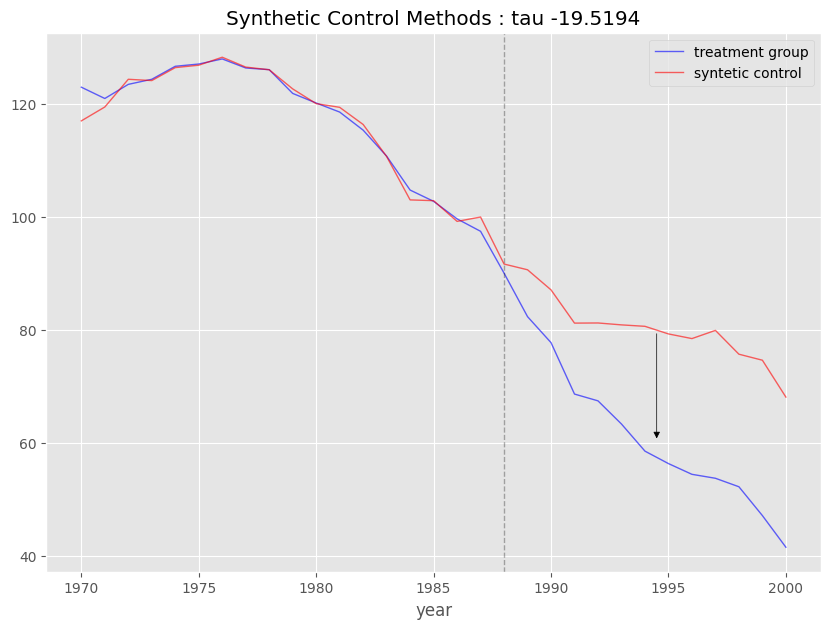

In [19]:
sdid.fit(zeta_type="base", simple_sc=False, additional_X=additional_X, additional_y=additional_y )
hat_omega_classic = sdid.estimated_params(model="sc")
sdid.plot(model="sc")

In [20]:
omega_result = pd.merge(
    hat_omega_simple.rename(columns={"sc_weight" : "smple_weight"}),
    hat_omega_classic.rename(columns={"sc_weight" : "classic_weight"}),
    on = "features",
    how="left"
)
omega_result.sum()

features          777.0
smple_weight        1.0
classic_weight      1.0
dtype: float64

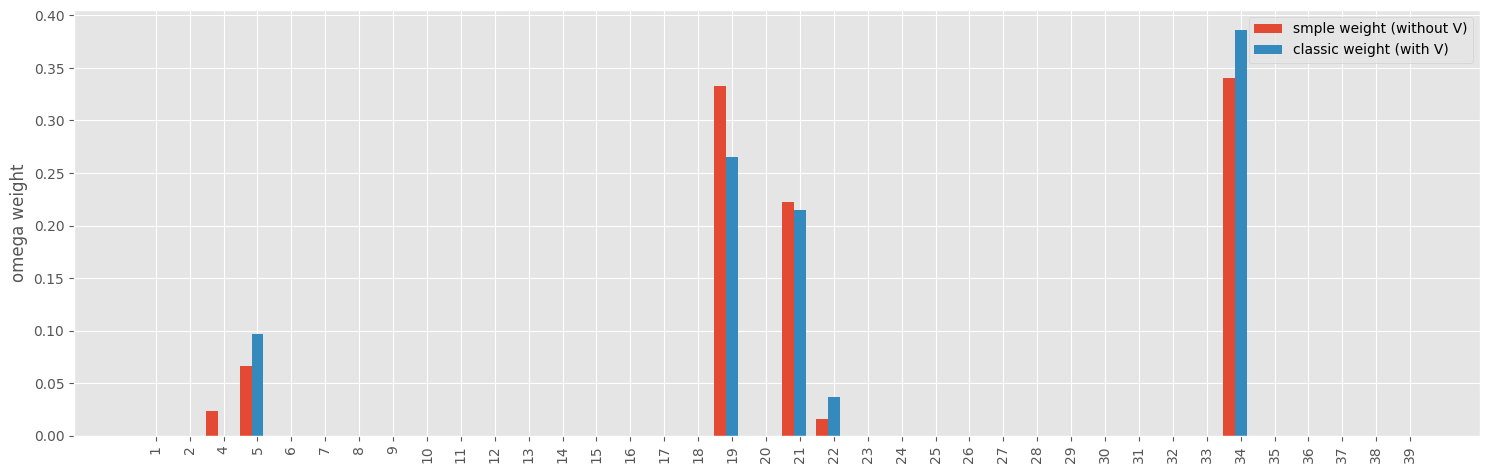

In [21]:
fig = plt.figure()
fig.set_figwidth(15)
ax = fig.add_subplot(1, 1, 1)
width = 0.35
ind = np.arange(len(omega_result))
ax.bar(ind - width, omega_result["smple_weight"], width, label="smple weight (without V)")
ax.bar(ind, omega_result["classic_weight"], width, label="classic weight (with V)")

ax.set_xticks(ind)
ax.set_xticklabels(omega_result["features"].values)
ax.legend()
ax.set_ylabel("omega weight")

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
len(sdid.caled_v)

In [22]:
sdid.caled_v

array([0.03619505, 0.03622522, 0.03578403, 0.03595659, 0.03578403,
       0.03617744, 0.07703506, 0.03605558, 0.0673712 , 0.03594363,
       0.03637158, 0.07219653, 0.09264364, 0.05680929, 0.03593039,
       0.06624544, 0.03588715, 0.0625267 , 0.03578403, 0.03653872,
       0.03653872])